In [131]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import seaborn as sns
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np

In [132]:
iris = sns.load_dataset("iris")

data = torch.tensor(iris[iris.columns[0:4]].values).float()

labels = torch.zeros(len(data), dtype=torch.long)
labels[iris.species =="versicolor"] = 1
labels[iris.species=="virginica"] = 2

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=.2)

trainData = TensorDataset(X_train, y_train)
testData = TensorDataset(X_test, y_test)

train_loader = DataLoader(trainData, batch_size=16)
test_loader = DataLoader(testData, batch_size=labels.shape[0])

# L2 regularization

In [133]:
def createModel(L2lambda):
    ANNiris = nn.Sequential(
        nn.Linear(4,64),
        nn.ReLU(),
        nn.Linear(64,64),
        nn.ReLU(),
        nn.Linear(64,3)
    )
    
    lossfun = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(ANNiris.parameters(), lr=.005, weight_decay=L2lambda)
    
    return ANNiris, lossfun, optimizer

def trainModel(ann, lossfun, optimizer):
    trainAcc = []
    testAcc = []
    losses = []
    
    for epoch in range(1000):
        batchAcc = []
        batchLoss = []
        for X,y in train_loader:
            y_pred = ann(X)
            
            loss = lossfun(y_pred,y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            batchAcc.append(100*torch.mean((torch.argmax(y_pred, axis=1) == y).float()).item())
            batchLoss.append(loss.item())
        
        trainAcc.append(np.mean(batchAcc))
        losses.append(np.mean(batchLoss))
        
        X,y = next(iter(test_loader))
        y_pred = ann(X)
        testAcc.append(100*torch.mean((torch.argmax(y_pred, axis=1) == y).float()).item())
    return trainAcc, testAcc, losses


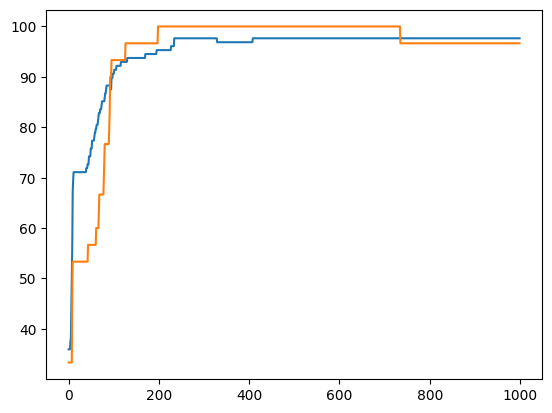

In [134]:
net, l, o = createModel(0.01)
train, test, loss = trainModel(net,l,o)
plt.plot(train)
plt.plot(test)

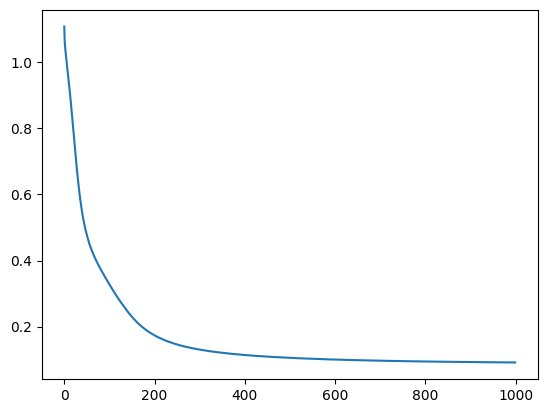

In [135]:
plt.plot(loss)

In [136]:
regularizations = np.linspace(0,1, 26)
results = np.zeros((len(regularizations), 3))
i = 0
for rl in regularizations:
    ann, lossfun, optimizer = createModel(rl)
    train, test, loss = trainModel(ann, lossfun, optimizer)
    results[i, 0] = np.mean(train[-10:])
    results[i, 1] = np.mean(test[-10:])
    results[i, 2] = np.mean(loss[-10:])
    i+=1

Text(0.5, 0, 'Regularization')

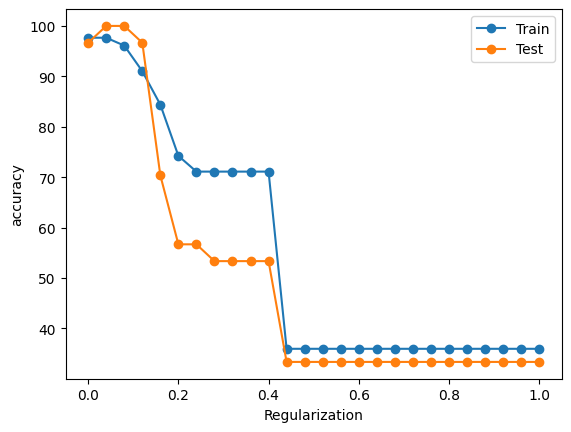

In [137]:
plt.plot(regularizations, results[:, :2], "o-")
plt.legend(["Train", "Test"])
plt.ylabel("accuracy")
plt.xlabel("Regularization")

Text(0.5, 0, 'Regularization')

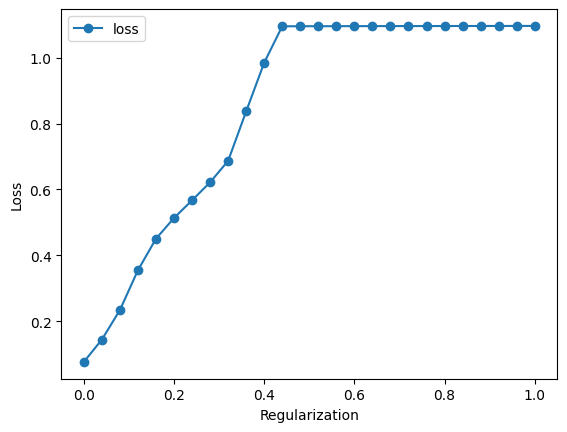

In [138]:
plt.plot(regularizations, results[:, 2:3], "o-")
plt.legend(["loss"])
plt.ylabel("Loss")
plt.xlabel("Regularization")

# L1 regularization

In [139]:
def createModel():
    ANNiris = nn.Sequential(
        nn.Linear(4,64),
        nn.ReLU(),
        nn.Linear(64,64),
        nn.ReLU(),
        nn.Linear(64,3)
    )
    
    lossfun = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(ANNiris.parameters(), lr=.005)
    
    return ANNiris, lossfun, optimizer


In [140]:
def trainModel(ann, lossfun, optimizer, L1lambda):
    trainAcc = []
    testAcc = []
    losses = []
    
    nweights = 0
    for pname, weight in ann.named_parameters():
        if "bias" not in pname:
            nweights += weight.numel()
    
    for epoch in range(1000):
        batchAcc = []
        batchLoss = []
        for X,y in train_loader:
            y_pred = ann(X)
            
            L1 = torch.tensor(0., requires_grad=True)
            for pname, weight in ann.named_parameters():
                if "bias" not in pname:
                    L1 = L1 + torch.sum(torch.abs(weight))
            
            loss = lossfun(y_pred,y)
            loss = loss + L1lambda * L1/nweights
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            batchAcc.append(100*torch.mean((torch.argmax(y_pred, axis=1) == y).float()).item())
            batchLoss.append(loss.item())
        
        trainAcc.append(np.mean(batchAcc))
        losses.append(np.mean(batchLoss))
        
        X,y = next(iter(test_loader))
        y_pred = ann(X)
        testAcc.append(100*torch.mean((torch.argmax(y_pred, axis=1) == y).float()).item())
        
    return trainAcc, testAcc, losses


In [141]:
tempmodel = createModel()[0]
for i in tempmodel.named_parameters():
    print(i[0], i[1].shape, i[1].numel())

0.weight torch.Size([64, 4]) 256
0.bias torch.Size([64]) 64
2.weight torch.Size([64, 64]) 4096
2.bias torch.Size([64]) 64
4.weight torch.Size([3, 64]) 192
4.bias torch.Size([3]) 3


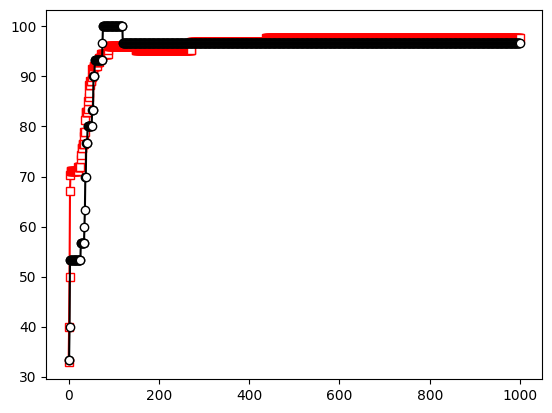

In [142]:
net, l, o = createModel()
lr = 0.01
train, test, loss = trainModel(net,l,o, lr)
plt.plot(train, "sr-", markerfacecolor="w")
plt.plot(test, "ko-", markerfacecolor="w")

In [143]:
regularizations = np.linspace(0,.1, 26)
results = np.zeros((len(regularizations), 3))
i = 0
for rl in regularizations:
    ann, lossfun, optimizer = createModel()
    train, test, loss = trainModel(ann, lossfun, optimizer, rl)
    results[i, 0] = np.mean(train[-10:])
    results[i, 1] = np.mean(test[-10:])
    results[i, 2] = np.mean(loss[-10:])
    i+=1

Text(0.5, 0, 'Regularization')

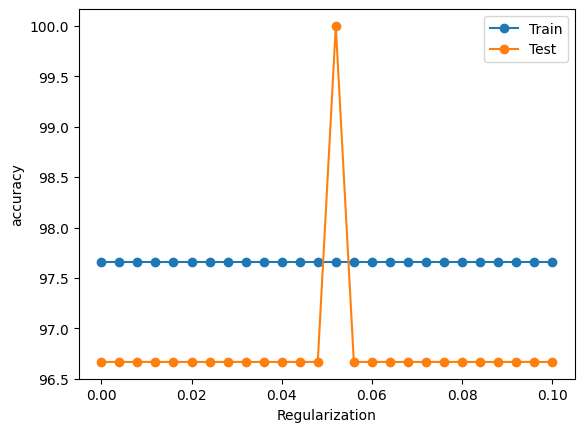

In [144]:
plt.plot(regularizations, results[:, :2], "o-")
plt.legend(["Train", "Test"])
plt.ylabel("accuracy")
plt.xlabel("Regularization")

Text(0.5, 0, 'Regularization')

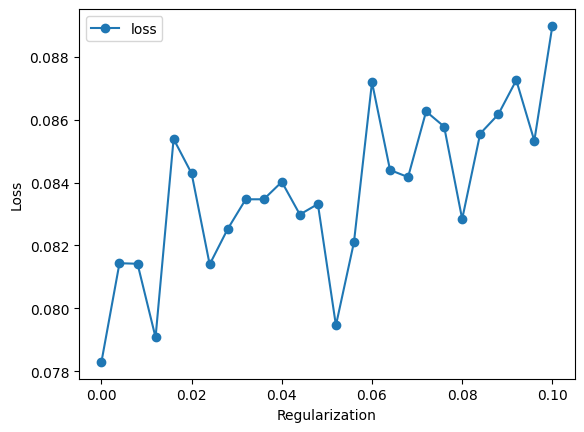

In [145]:
plt.plot(regularizations, results[:, 2:3], "o-")
plt.legend(["loss"])
plt.ylabel("Loss")
plt.xlabel("Regularization")